In [1]:
import qiskit
from qiskit import QuantumCircuit

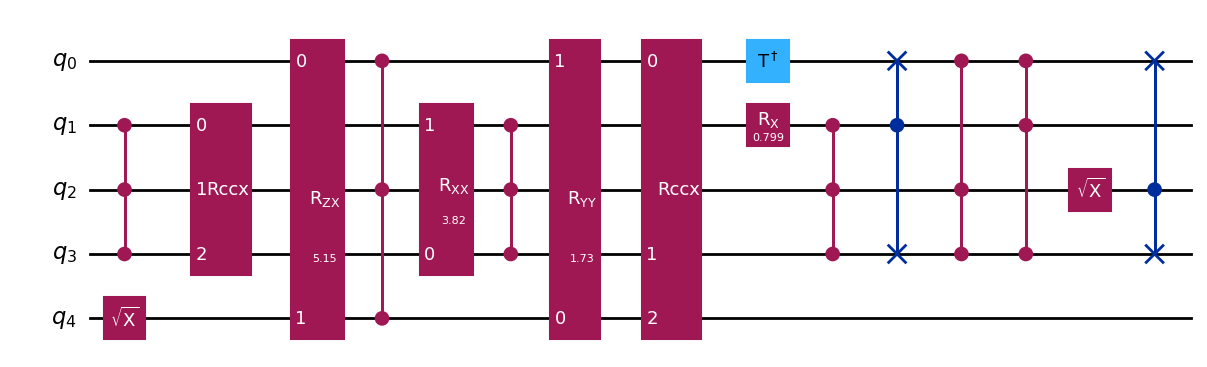

In [2]:
from qiskit.circuit.random import random_circuit


circ = random_circuit(num_qubits=5, depth=10)
circ.draw('mpl')

In [3]:
from qiskit.circuit.library import XGate, ZGate, HGate, CXGate, CZGate
GATES = {'x':XGate, 'h':HGate, 'z':ZGate, 'cx': CXGate, 'cz': CZGate}
QUBITS_FOR_GATES = {'x':1, 'h':1, 'z':1, 'cx': 2, 'cz':2}

import random

def generate_random_circuit(num_qubits: int, num_gates: int, gate_dist:dict=None):
    circuit = QuantumCircuit(num_qubits)

    if gate_dist is None:
        gate_dist = {gate:1/len(GATES) for gate in GATES}

    # print(gate_dist)
    gates = random.choices(
        population=list(gate_dist.keys()), 
        weights=list(gate_dist.values()), 
        k=num_gates)
    
    for gate in gates:
        gate_q = QUBITS_FOR_GATES.get(gate)
        gate_f = GATES.get(gate)
        q = random.sample(population=range(num_qubits), k=gate_q)

        print(gate, q)

        circuit.append(gate_f(), q)

    return circuit


In [4]:
gatedist = {'h':0.5, 'cx':0.5}

h [3]
h [0]
cx [0, 3]
h [0]
cx [0, 4]
cx [3, 1]
cx [4, 1]
cx [4, 2]
h [4]
cx [1, 4]
h [3]
cx [1, 2]
h [2]
cx [1, 3]
h [0]
h [1]
cx [2, 0]
cx [0, 1]
h [2]
cx [0, 1]
cx [2, 1]
cx [3, 0]
cx [3, 4]
h [1]
cx [3, 4]
cx [1, 2]
h [0]
cx [3, 1]
h [1]
h [4]
h [2]
cx [1, 4]
h [4]
cx [4, 1]
cx [4, 2]
h [0]
h [1]
cx [2, 1]
h [2]
h [2]
h [0]
cx [2, 0]
cx [2, 1]
h [4]
h [1]
h [4]
cx [4, 2]
h [0]
cx [2, 0]
cx [1, 2]
h [1]
cx [2, 4]
h [1]
cx [2, 4]
h [2]
cx [3, 4]
h [2]
cx [1, 0]
cx [3, 4]
h [0]
cx [2, 3]
cx [1, 4]
h [3]
h [0]
cx [4, 2]
cx [2, 4]
h [4]
cx [1, 4]
cx [2, 1]
h [2]
cx [0, 2]
cx [4, 0]
cx [3, 0]
h [3]
h [2]
cx [3, 4]
cx [2, 3]
h [4]
h [0]
cx [4, 2]
h [0]
cx [2, 1]
h [0]
h [2]
cx [3, 2]
h [3]
cx [4, 2]
h [1]
h [3]
cx [0, 2]
cx [4, 2]
cx [4, 1]
cx [3, 1]
cx [2, 4]
h [3]
h [2]
cx [3, 0]
h [0]
h [3]
h [1]


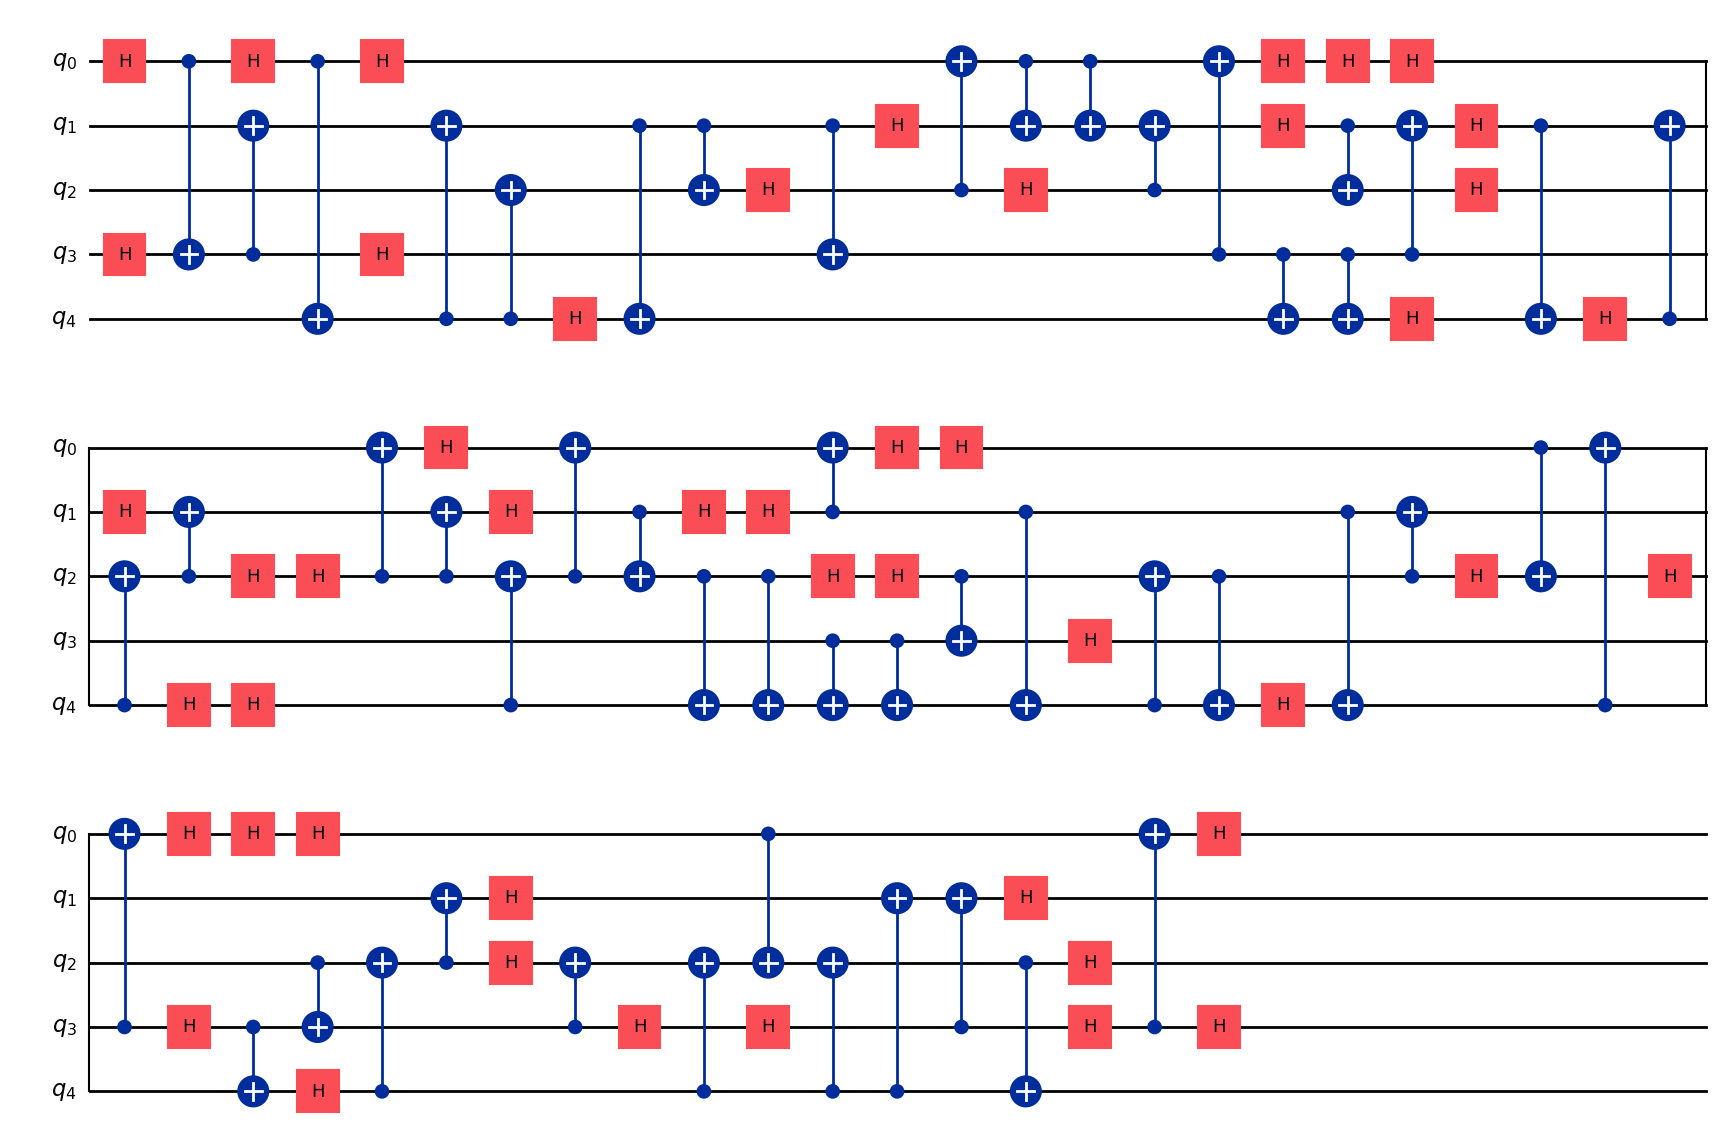

In [5]:
c = generate_random_circuit(5,100, gatedist)

c.draw('mpl')

In [6]:
import sys
sys.path.append('../')

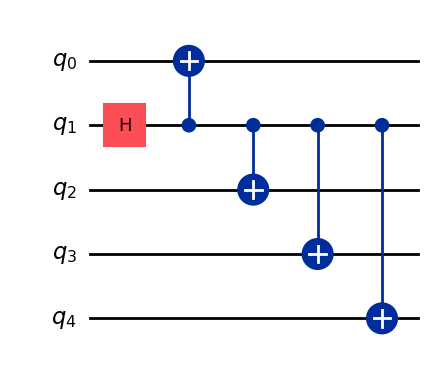

In [7]:
# from simulator.simulate import run_circuit_pennylane
from circuits.generate_circuits import custom_ghz
c = custom_ghz(5,1)
c.draw('mpl')

In [8]:
import pennylane as qml
from qiskit.quantum_info import Operator
import numpy as np
from collections import Counter

def run_circuit_pennylane(circuit:QuantumCircuit, shots=2**10):
    
    num_qubits = circuit.num_qubits

    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)

    @qml.qnode(dev, interface="torch", diff_method=None)
    def sample_qnode(U_big):
        # inject your Qiskit-built circuit (now re-indexed)
        qml.QubitUnitary(U_big, wires=range(num_qubits))
        # full-register sampling
        return qml.sample(wires=range(num_qubits))
        
    circuit_op = Operator(circuit.remove_final_measurements(inplace=False)).data
    perm = [int(f"{i:0{num_qubits}b}"[::-1], 2) for i in range(2**num_qubits)] 
    circuit_op_pennylane =  circuit_op[np.ix_(perm, perm)] 
    samples = sample_qnode(circuit_op_pennylane)

    bitstrings = ["".join(str(bit.item()) for bit in samp) for samp in samples]

    return Counter(bitstrings)




In [9]:
samples = run_circuit_pennylane(c)

samples

Counter({'00000': 512, '11111': 512})

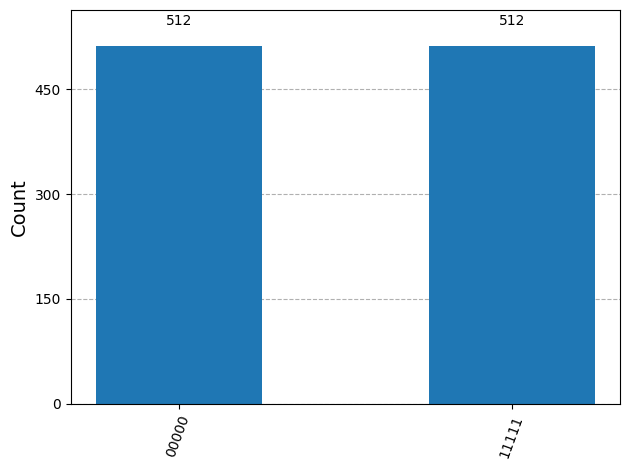

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(samples)